In [406]:
import numpy as np
import random
import matplotlib.pyplot as plt
import numba
import time
import os
from datetime import datetime


In [407]:
def create_lattice(lattice_length, T_num, B_num):
    lattice = np.zeros([lattice_length, lattice_length])
    
    # Place T's randomly
    t_coords = np.empty((2, 0), dtype=int)  # Initialize as an empty array
    while t_coords.shape[1] < T_num:  # Check the number of columns
        t = np.array([[np.random.randint(lattice_length)], [np.random.randint(lattice_length)]])
        if not np.any(np.all(t == t_coords, axis=0)):
            t_coords = np.hstack((t_coords, t))
            lattice[t[0, 0], t[1, 0]] = 1
    
    # Place B's randomly
    b_coords = np.empty((2, 0), dtype=int)  # Initialize as an empty array
    while b_coords.shape[1] < B_num:  # Check the number of columns
        b = np.array([[np.random.randint(lattice_length)], [np.random.randint(lattice_length)]])
        if not np.any(np.all(b == b_coords, axis=0)) and not np.any(np.all(b == t_coords, axis=0)):
            b_coords = np.hstack((b_coords, b))
            lattice[b[0, 0], b[1, 0]] = 2
    
    empty_coords = np.argwhere(lattice == 0).T
    
    return lattice, t_coords, b_coords, empty_coords

In [457]:
# showing lattices as they evolve 

def lattice_plots(lattice_history, selected_indices):

    cmap = plt.cm.colors.ListedColormap(['white', 'blue', 'red'])

    for i in range(len(selected_indices)):

        # Create a plot
        plt.imshow(lattice_history[i], cmap=cmap, extent=[0, size, 0, size])
        plt.colorbar(ticks=[0, 1, 2], label="Legend")
        plt.title("Lattice with T's (Blue) and B's (Red)")

  

        #plt.title(f"Lattice at Iteration {selected_indices[i]}")  # Add a title with the iteration number

        #fig_name = f"Plot\Lattice_iter{selected_indices[i]}"
        # plt.savefig(fig_name)
        plt.show()
        

In [621]:
def position_random(pos):
    col = np.random.randint(pos.shape[1])
    p = pos[:,col]
    #print(pos)
    #print(p)
    return p, col

In [622]:

def energy(lattice, ID_in, pos_hypo, interaction_matrix):
    s = lattice.shape[0]-1
    i = pos_hypo[0] # x coordinate
    j = pos_hypo[1] # y coordinate
    
    if i==0:
        up = lattice[s,j]   
    else:    
        up = lattice[i-1,j]
    up = int(up)

    if i == s:
        down = lattice[0,j]      
    else:
        down = lattice[i+1,j]
    down = int(down)

    if j == 0:
        left = lattice[i,s]        
    else:
        left = lattice[i,j-1]    
    left = int(left)

    if j == s:
        right = lattice[i,0]       
    else:
        right = lattice[i,j+1]
    right = int(right)
    
    
    E = -(interaction_matrix[ID_in, up] + interaction_matrix[ID_in, down] + interaction_matrix[ID_in, left] + 
          interaction_matrix[ID_in, right])
    return E

In [623]:
# total energy of lattice
def lattice_energy(lattice, eps):
    
    E_total = 0
    rows, cols = lattice.shape

    for i in range(rows):
        for j in range(cols):
            val = int(lattice[i, j])
            E_total += energy(lattice, val, (i, j), eps)

    E_total = E_total / 2
    
    return E_total


In [624]:
# check if object moves. pos1 is the coordinates of all objects where one is to be moved. 
# most likely a Tcell
# pos0 are coordinates of holes in the lattice 

def evaluate_particle_move(lattice, pos1, pos0, T, E_total, eps):
    
    p1, col1 = position_random(pos1)
    ID_in = lattice[p1[0], p1[1]]
    ID_in = int(ID_in)
    Ein = energy(lattice,ID_in, p1, eps)
    #print("Ein",Ein)
    p0, col0 = position_random(pos0)
    # seeing what energy would be for particle if it moved the the chosen empty location
    lattice[p1[0], p1[1]] = 0 # temporarily moving object so not to be seen as neighbor by itself
    Efin = energy(lattice, ID_in, p0, eps)
    #print(,"Efin:",Efin)   
    Ediff = Efin - Ein


    if Ediff < 0 :
        move = True
    
    else:
        probability = np.exp(-Ediff/T)
        if random.random() < probability: # random.random gives between 0 and 1. Hence higher prob -> more move
            move = True 
        else:
            move = False
        
    if move: 
        lattice[p0[0], p0[1]] = 1
        # update arrays containing coordinates of 0's and 1's
        pos1[:,col1] = [p0[0], p0[1]]
        pos0[:,col0] = [p1[0], p1[1]]
        E_total = E_total + Ediff
        E_total = float(E_total)
        
    else:
        lattice[p0[0], p0[1]] = 0
        lattice[p1[0], p1[1]] = 1
    #print(E_total, Ediff)
    return lattice, pos1, pos0, E_total

In [729]:

def monte_carlo(Temp, eps, lattice_length, T_num, B_num, num_runs, num_lattices_to_store=None):
    lattice, pos1, b_coords, pos0 = create_lattice(lattice_length, T_num, B_num)
    E_lattice = lattice_energy(lattice, eps)
   
    # Create a colormap for red (B) and blue (T)
    cmap = plt.cm.colors.ListedColormap(['white', 'blue', 'red'])

    # Plot the lattice
    plt.imshow(lattice, cmap=cmap, extent=[0, lattice_length, 0, lattice_length])
    plt.colorbar(ticks=[0, 1, 2], label="Legend")
    plt.title("Lattice with T's (Blue) and B's (Red)")
    #plt.grid(True, linewidth=0.5, color='black')
    plt.show()
    
    E_history = {}
    for ind, t in enumerate(Temp):
        #lattice_history = []
        E_history_for_Temp = []
        #for temperature in T:

        for i in range(0,num_runs): # change to from one and append initial E and lattice to outisde
            E_history_for_Temp.append(E_lattice)
            
            lattice, pos1, pos0, E_lattice = evaluate_particle_move(
                                             lattice, pos1, pos0, t, E_lattice, eps)
            #lattice_history.append(lattice.copy())
            
        E_history[t] = E_history_for_Temp.copy()
        
    current_datetime = datetime.now()
    datetime_str = current_datetime.strftime('%Y%m%d-%H-%M')    
    run_name = f'{datetime_str}'
    
    return lattice, E_history, run_name

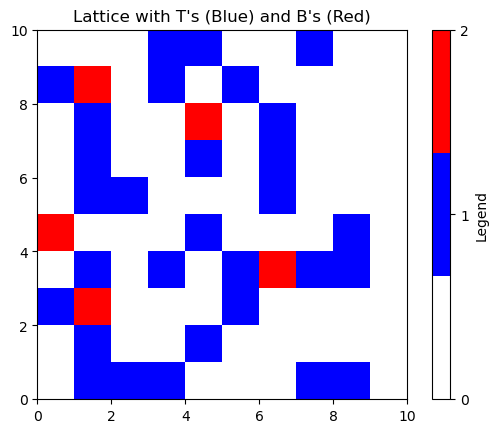

In [730]:
# the interaction matrix can be used to decide how many bacteria are able to multiply. 
# if surrounded by T cells -> no division
# the body is modelled by an N by N lattice

num_runs = 100
Temp = np.arange(3,0.1,-0.1)

size = 10

T_num_in = 30    # number of initial T-cells
B_num_in = 5

BB_int = 0      # interaction energy between bacterias
TT_int = 0      # interaction energy between T-cells
BT_int = 1     # interaction energy between bacteria and T-cells
interaction_matrix = np.array([
    [0, 0, 0],
    [0, TT_int, BT_int],
    [0, BT_int, BB_int]
])

lattice, E_history, run_name = monte_carlo(
    Temp, interaction_matrix, size, T_num_in, B_num_in, num_runs, num_lattices_to_store=None)



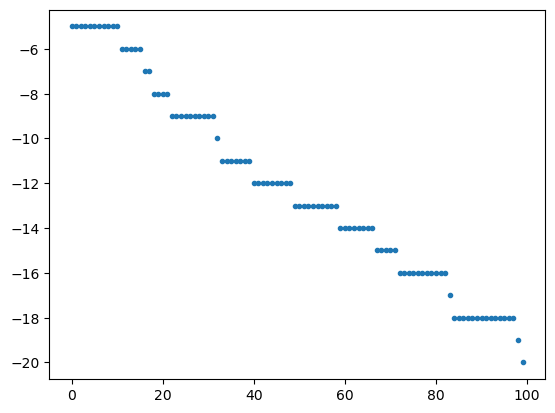

In [731]:
plt.figure()
plt.plot(E_lattice,'.', )
plt.show()

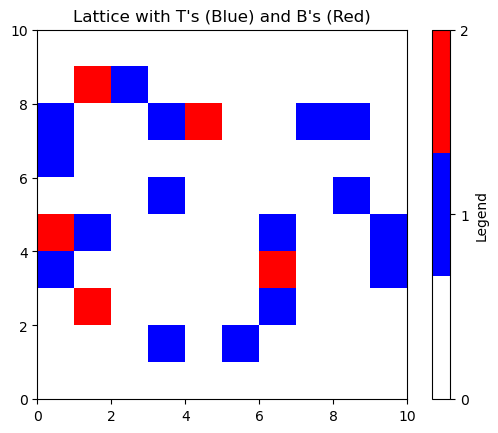

In [732]:
# Create a colormap for red (B) and blue (T)
cmap = plt.cm.colors.ListedColormap(['white', 'blue', 'red'])

# Plot the lattice
plt.imshow(lattice, cmap=cmap, extent=[0, size, 0, size])
plt.colorbar(ticks=[0, 1, 2], label="Legend")
plt.title("Lattice with T's (Blue) and B's (Red)")
#plt.grid(True, linewidth=0.5, color='black')
plt.show()

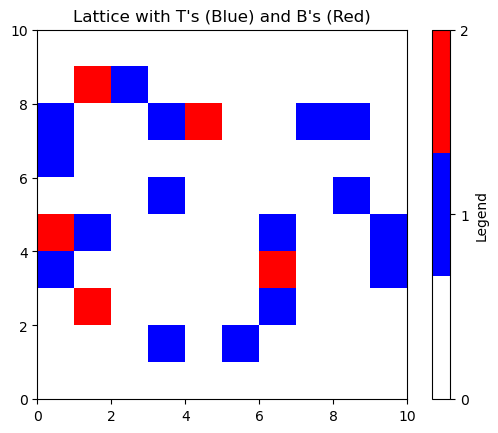

In [733]:
# Create a colormap for red (B) and blue (T)
cmap = plt.cm.colors.ListedColormap(['white', 'blue', 'red'])

# Plot the lattice
plt.imshow(lattice, cmap=cmap, extent=[0, size, 0, size])
plt.colorbar(ticks=[0, 1, 2], label="Legend")
plt.title("Lattice with T's (Blue) and B's (Red)")
#plt.grid(True, linewidth=0.5, color='black')
plt.show()

In [734]:
# mean energy and variance hereof of lattice

def mean_energyWITHDENSITY(T, density, E_history, ind_equilibrium):

    E_mean = np.zeros([len(T),len(density)])
    E_variance = np.zeros([len(T),len(density)])

    for j in density:
        E = E_history[j]
        for i in T:
            E_mean[i][j] = np.mean(E[i][ind_equilibrium:-1])
            E_variance[i][j] = np.var(E[i][ind_equilibrium:-1])

    return E_mean, E_variance


In [737]:
def mean_energy(T, E_history, ind_equilibrium):
    
    E = E_history
    E_mean = np.zeros([len(T)])
    E_variance = np.zeros([len(T)])

    for ind,t in enumerate(T):
        E_mean[ind] = np.mean(E[t][ind_equilibrium:-1])
        E_variance[ind] = np.var(E[t][ind_equilibrium:-1])

    return E_mean, E_variance

ind_equi = int(2/3*num_runs) # index where equilibrium is assumed. 
E_mean, E_var = mean_energy(Temp, E_history, ind_equi)

E_mean

array([ -6.57575758,  -7.18181818,  -4.96969697,  -8.63636364,
        -6.87878788,  -8.33333333,  -9.39393939,  -9.81818182,
       -11.93939394, -10.63636364, -13.75757576, -13.54545455,
       -12.63636364, -13.06060606, -14.36363636, -17.33333333,
       -18.        , -19.63636364, -17.45454545, -20.        ,
       -20.33333333, -20.51515152, -22.42424242, -23.51515152,
       -22.66666667, -25.81818182, -32.45454545, -40.3030303 ,
       -47.33333333])

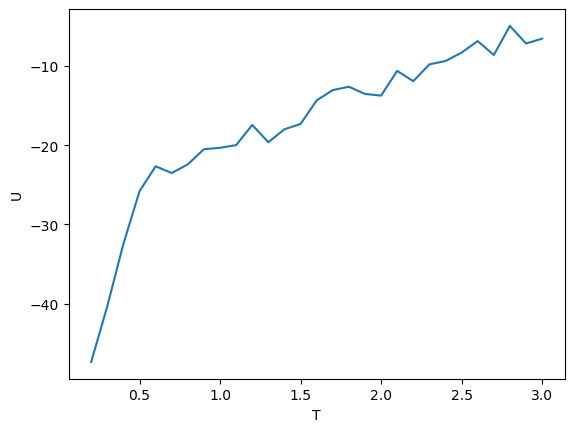

In [738]:
plt.figure()
plt.plot(Temp,E_mean)
plt.xlabel('T')
plt.ylabel('U')
plt.show()

In [740]:
# SAVE DATA 

current_dir = os.getcwd()

# directory of Data folder
new_dir = f'{current_dir}/Data/'

# Save data there
file_spec = 'test'
file_name = f'{run_name}_{file_spec}.npz'
file_dir = f'{new_dir}{file_name}'

np.savez(file_dir, 
         T = Temp,
         E_mean = E_mean,
         E_variance = E_var,
         num_runs = num_runs,
         eps = interaction_matrix,
        )
#np.savez(file_dir, T = T, density = density, E_mean = E_mean, E_variance=E_var, num_runs = num_runs, MinLatticeSize = size_mini, eps=eps, execution_time=execution_time )
